In [10]:
import pickle
import matplotlib.pyplot as plt

***Research Question***

Explore the relationship between comments and ratings of Kdramas and Jdramas. 2 major components: use comments to predict rating and use rating to predict comments.

***Data Collection and Cleaning***

Source: http://asianwiki.com/Main_Page

data = []

mchain = {}

additional_columns = ["Network", "Episodes", "Country", "Language", "Title"]


for url in urls:
    #Bug in website
    if url == urls[117]:
        url = url[:len(urls[117]) - 1]
    
    kdrama = {"Network": "", 
            "Episodes": -1,
            "Country": "", 
            "Language": "", 
             "Title" : ""}
    req = requests.get(url)
    soup  = BeautifulSoup(req.content, "html.parser")
    content = soup.find("div", {"id":"mw-content-text"})

    #Rating
    rating_content = content.findAll("b")
    try:
        kdrama["rating"] = float(rating_content[0].text.split("/")[0].rstrip().lstrip())
    except (ValueError, IndexError) as e:
        kdrama["rating"] = float('NaN')

    #Comments
    comments = []
    comments_char_len = 0
    comments_word_len = 0
    for div in content.findAll("div", {"class":"comment-item"}):
        comment = div.text.replace('\xa0', "").split('\n')[2]
        comments.append(comment)
        comments_char_len += len(comment)
        comments_word_len += len(comment.split(" "))
    kdrama["comments"] = " ".join(comments)
    kdrama["no_comments"] = len(comments)
    if len(comments) != 0:
        kdrama["avg_comment_char_len"] = comments_char_len / len(comments)
        kdrama["avg_comment_word_len"] = comments_word_len / len(comments)
    else:
        kdrama["avg_comment_char_len"] = 0
        kdrama["avg_comment_word_len"] = 0
    if kdrama["rating"] not in mchain:
        mchain[kdrama["rating"]] = comments
    else: 
        mchain[kdrama["rating"]] += comments
    
    #Title
    titles = soup.findAll("h1")
    if len(titles) >= 1:
        kdrama["Title"] = titles[0].get_text()
    
    #Network, Country, Language, Episodes
    for ils in soup.findAll("li"):
        text = ils.get_text()
        components = text.split(":")
        if components[0].strip() in additional_columns: 
            kdrama[components[0].strip()] = components[1].strip()
    
    data.append(kdrama)
    time.sleep(0.25)

**No Comments Handling:**
Some dramas didn't have comments. Should I count declare the comments column of the Data Frame as NaN or ""? I decided to go with the later on the assumption that having no comments can essentially be all the comment the raters have. 

**Bug in the website:** I had an issue with one of the url giving me NaN values even though there were clearly valid data on the site. Apparently, the hyperlink in the page where I got all the URLs was incorrect (if I in-person clicked the hyper-text link, it would direct me to an invalid page). 

***Data Visualization***

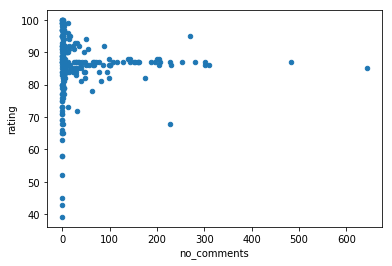

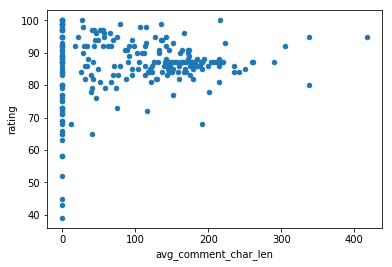

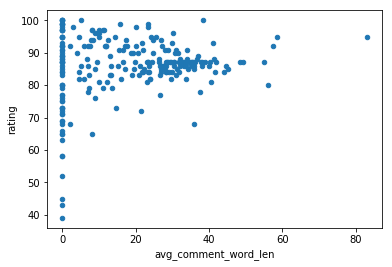

In [17]:
comments_df = pickle.load(open("comments_df.pkl", "rb"))
comments_df.plot.scatter(x="no_comments", y="rating")
comments_df.plot.scatter(x="avg_comment_char_len", y="rating")
comments_df.plot.scatter(x="avg_comment_word_len", y="rating")

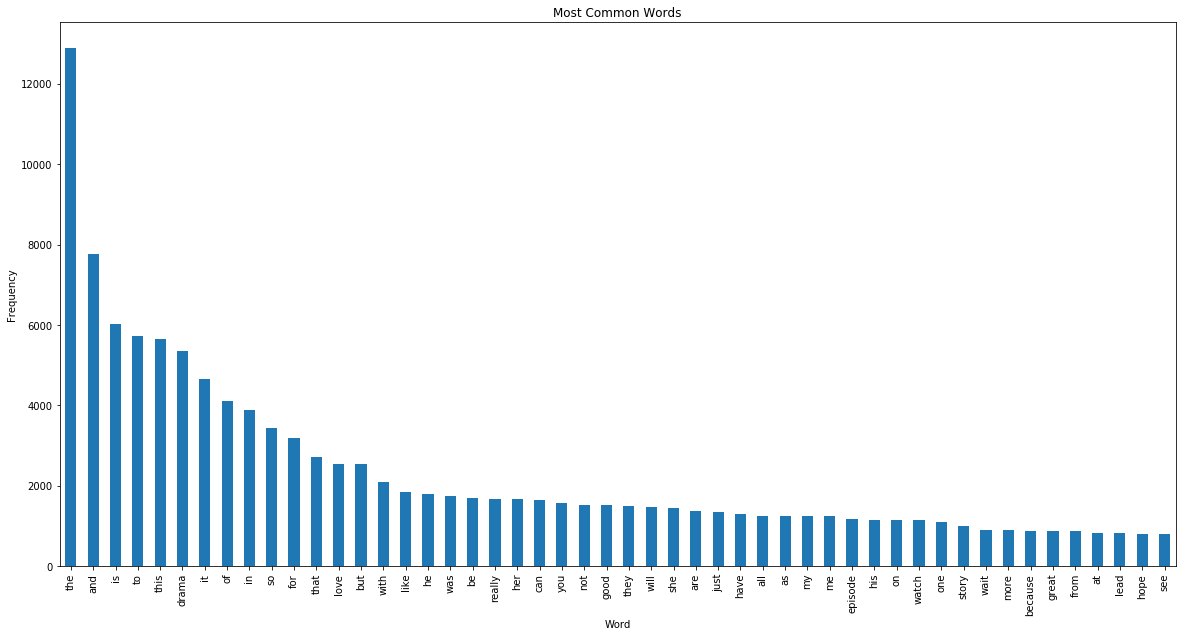

In [35]:
ngram1 = pickle.load(open("graphngram1.pkl", "rb"))
plt.figure(figsize=(20,10))
plt.title("Most Common Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
ngram1.plot.bar()

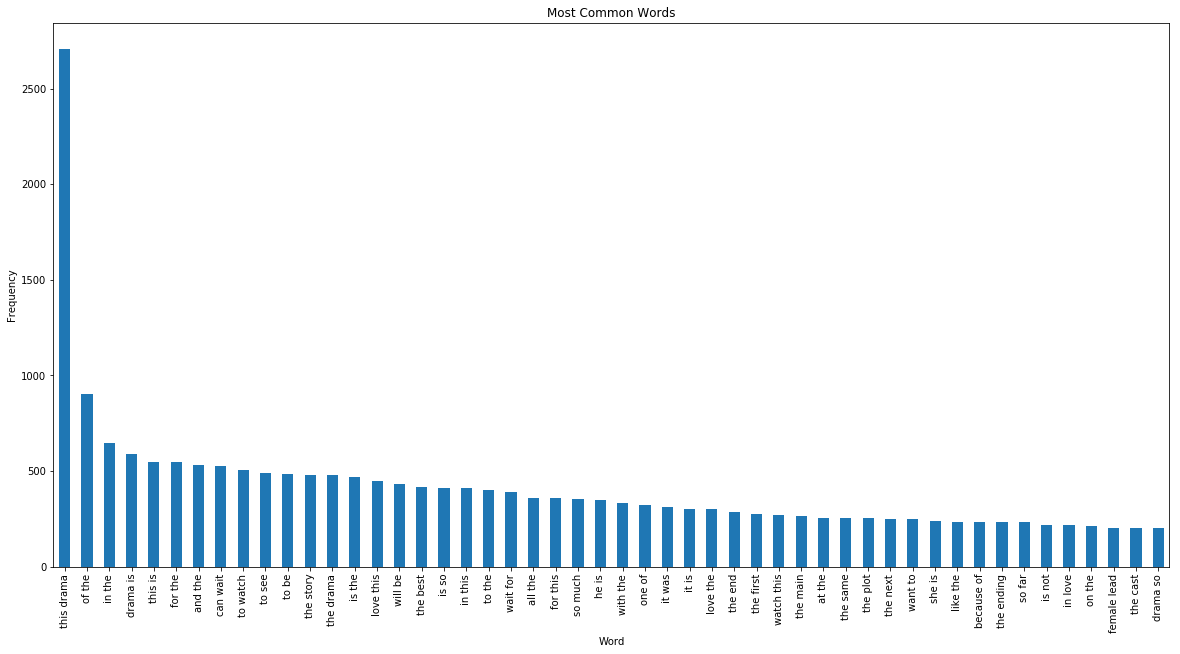

In [14]:
ngram2 = pickle.load(open("graphngram2.pkl", "rb"))
plt.figure(figsize=(20,10))
plt.title("Most Common Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
ngram2.plot.bar()

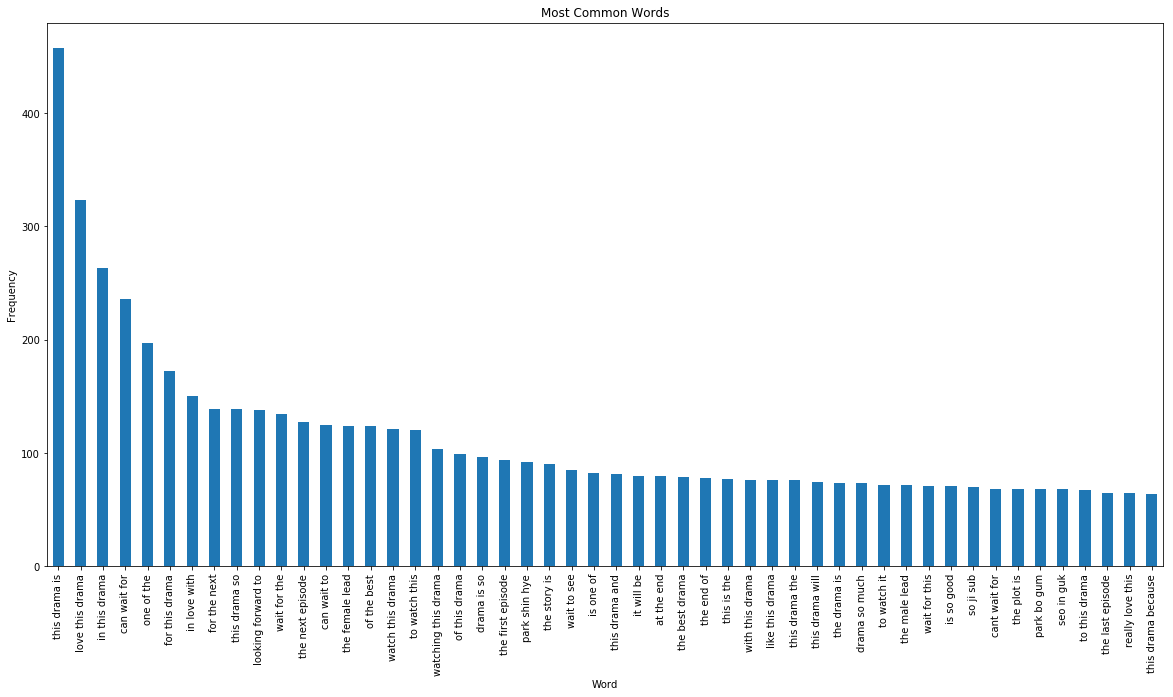

In [15]:
ngram3 = pickle.load(open("graphngram3.pkl", "rb"))
plt.figure(figsize=(20,10))
plt.title("Most Common Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
ngram3.plot.bar()

***Machine Learning***

(87, 9.59552331099185)

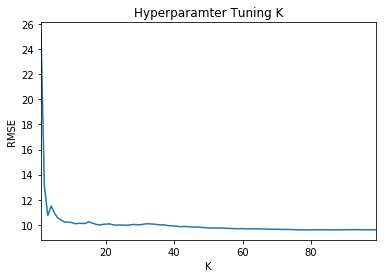

In [27]:
kmeans = pickle.load(open("kmeans.pkl", "rb"))
plt.title("Hyperparamter Tuning K")
plt.xlabel("K")
plt.ylabel("RMSE")
kmeans.plot.line()
(kmeans.idxmin(), kmeans.min())

(0.039, 11.407177440815788)

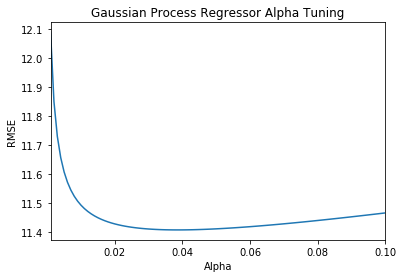

In [26]:
gpr_alpha_series = pickle.load(open("gpr_alpha.pkl", "rb"))
plt.title("Gaussian Process Regressor Alpha Tuning")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
gpr_alpha_series.plot.line()
(gpr_alpha_series.idxmin(), gpr_alpha_series.min())

(200, 36.81687338501499)

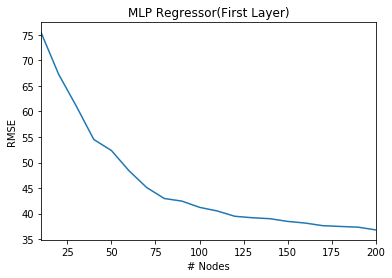

In [29]:
mlp1 = pickle.load(open("mlp1.pkl", "rb"))
mlp2 = pickle.load(open("mlp2.pkl", "rb"))
mlp3 = pickle.load(open("mlp3.pkl", "rb"))
mlp_iter = pickle.load(open("mlp_iter.pkl", "rb"))

plt.title("MLP Regressor(First Layer)")
plt.xlabel("# Nodes")
plt.ylabel("RMSE")
mlp1.plot.line()
(mlp1.idxmin(), mlp1.min())

(180, 9.893811793555113)

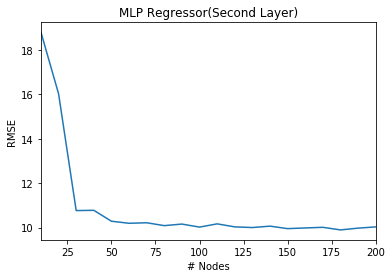

In [30]:
plt.title("MLP Regressor(Second Layer)")
plt.xlabel("# Nodes")
plt.ylabel("RMSE")
mlp2.plot.line()
(mlp2.idxmin(), mlp2.min())

(150, 9.491021062368482)

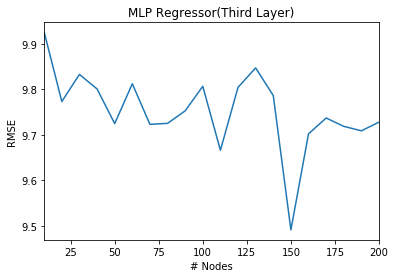

In [31]:
plt.title("MLP Regressor(Third Layer)")
plt.xlabel("# Nodes")
plt.ylabel("RMSE")
mlp3.plot.line()
(mlp3.idxmin(), mlp3.min())

(300, 9.553164534744509)

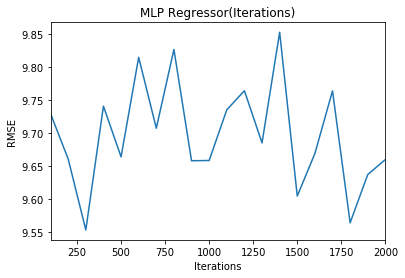

In [33]:
plt.title("MLP Regressor(Iterations)")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
mlp_iter.plot.line()
(mlp_iter.idxmin(), mlp_iter.min())

In [22]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LinearRegression
class RegressionEnsembler(BaseEstimator, RegressorMixin):
    """Creates an ensemble model out of a collection of individual estimators
    
    Args:
      estimators: A list containing the individual estimators.
      learn_weights: A boolean that specifies whether we should learn the
        "optimal" weights/coefficients to apply to each individual estimator's
        predictions. If False, we simply return the straight average of the 
        individual estimators' predictions as the ensemble prediction.
    """
    
    def __init__(self, estimators, learn_weights=True):
        self.estimators = estimators
        self.learn_weights = learn_weights
        
    def fit(self, X, y):
        # check that X and y have the correct shape
        X, y = check_X_y(X, y)
        
        # store the training features and the labels
        self.X_ = X
        self.y_ = y
        
        # call the fit method of each of the estimators
        for estimator in self.estimators:
            estimator.fit(X, y)
            
        # if we wish to learn the "optimal" weights from the training data
        if self.learn_weights:
            # get prediction from each estimator on the training data
            predictions = []
            for estimator in self.estimators:
                predictions.append(estimator.predict(X))
            Y_ = np.column_stack(predictions)
        
            # fit linear regression on top of the estimators' predictions
            self.ensembler = LinearRegression(fit_intercept=False)
            self.ensembler.fit(Y_, y)
            
        return self
    
    def predict(self, X):
        # check that fit has been called
        check_is_fitted(self, ['X_', 'y_'])
        
        # check that X has the right form
        X = check_array(X)
        
        # calculate predictions from the estimators
        predictions = []
        for estimator in self.estimators:
            predictions.append(estimator.predict(X))
        Y_ = np.column_stack(predictions)
        
        # return predictions
        if self.learn_weights:
            return self.ensembler.predict(Y_)
        else:
            return Y_.mean(axis=1)
model = pickle.load(open("model.pkl", "rb"))
model

RegressionEnsembler(estimators=[KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=87, p=2,
          weights='uniform'), MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, ep...e=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)],
          learn_weights=False)

In [23]:
model_result = pickle.load(open("model_result.pkl", "rb"))
model_result

(9.620903424844128, 9.914297561193337, 9.89116310515767, 9.605758741650307)

In [18]:
#Bigram Markov Chain Results
generated_comments = pickle.load(open("gcomments.pkl", "rb"))
generated_comments
for x in generated_comments:
    print(str(x) + ": ")
    for comment in generated_comments[x]:
        if len(comment) > 0: 
            print("\t- " + comment)

0: 
10: 
20: 
30: 
40: 
50: 
60: 
	- i didn't feel an iota of satisfaction as there isn't a single story without it for me if ms. fairy husband was the reincarnation of her son was born as a jerk). and about geum, do people really watch this because kang mina (gugudan) project, can't
	- i failed to understand why he was also in river bran. then the unsolved question is the main story which is completely absurd and its just a miracle that web comic version got adapted into a tv
	- tbh, if ever ms. fairy to end up together though. who
	- the worst drama i have been tricked
	- an appropriate title for this
	- their are a lot better." i'll stand by that it has a pure heart. fighting kang sora-ya!!! just watch this regarding on the story
70: 
	- technically the parents usually collect the money. guests give to the one beside the main leads sparks a very cute and innocent chemistry..its a light drama, but the story unfolds and how each character connects with one
	- wow!! yay! moon chae-won 